# Data cleaning


In [1]:
import pandas as pd
import numpy as np

In [2]:
import tensorflow as tf 
tf.test.gpu_device_name()


'/device:GPU:0'

In [3]:
# Load csv
jfk = pd.read_csv('/content/JFK_flight_data.csv')

# Drop null values
jfk = jfk.dropna()

# One-hot encoding for categorical variables
one_hot = pd.get_dummies(jfk['OP_UNIQUE_CARRIER'])
jfk = jfk.drop('OP_UNIQUE_CARRIER',axis = 1)
jfk = jfk.join(one_hot)

one_hot = pd.get_dummies(jfk['DEST'])
jfk = jfk.drop('DEST',axis = 1)
jfk = jfk.join(one_hot)

one_hot = pd.get_dummies(jfk['Wind'])
jfk = jfk.drop('Wind',axis = 1)
jfk = jfk.join(one_hot)

one_hot = pd.get_dummies(jfk['Condition'])
jfk = jfk.drop('Condition',axis = 1)
jfk = jfk.join(one_hot)

jfk.loc[jfk['MONTH']==1, 'MONTH'] = 'Jan'
jfk.loc[jfk['MONTH']==11, 'MONTH'] = 'Nov'
jfk.loc[jfk['MONTH']==12, 'MONTH'] = 'Dec'
one_hot = pd.get_dummies(jfk['MONTH'])
jfk = jfk.drop('MONTH', axis = 1)
jfk = jfk.join(one_hot)

# Drop unneeded columns
jfk = jfk.drop(columns = ['TAIL_NUM','DEP_TIME_M'])

# Change type of Dew Point column to int
jfk['Dew Point'] = jfk['Dew Point'].astype(int)


# Train-test-validation split

In [4]:
# Train-test split

from sklearn.model_selection import train_test_split

X,y = jfk.loc[:, jfk.columns != 'DEP_DELAY'], jfk.loc[:, 'DEP_DELAY']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=604)

# Train-validation split

X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=604)

In [ ]:
# Test baseline model of average

from sklearn.metrics import mean_squared_error as mse

print('rmse for validation set is', np.sqrt(mse(y_val, y_train.mean()*np.ones(len(y_val)))))
print('rmse for test set is', np.sqrt(mse(y_test, y_train.mean()*np.ones(len(y_test)))))

rmse for validation set is 37.02477781979254
rmse for test set is 36.235234518989124


# Decision tree regressors

In [ ]:
# Decision tree regressor with default hyperparameters

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse  


reg = DecisionTreeRegressor()
model = reg.fit(X_train_train,y_train_train)
pred = model.predict(X_val)

print('rmse is ', np.sqrt(mse(y_val, pred)))

rmse is  36.75231415797062


In [ ]:
# Hyperparameter tuning with GridSearchCV

from sklearn.model_selection import GridSearchCV

param_grid = { 
    'splitter': ['best','random'],
    'min_samples_leaf': [1,3,10],
    'min_weight_fraction_leaf': [0.0,0.2,0.5],
    'max_features': ['log2','sqrt',None],
    'max_depth': [None,5,10,50,100],
    'min_samples_split': [2,5,10,20]
}

grid_cv = GridSearchCV(DecisionTreeRegressor(),
                          param_grid = param_grid, 
                          cv = 5,
                          verbose=0.5)

grid_cv.fit(X_train, y_train)

print(grid_cv.best_params_)

Fitting 5 folds for each of 1080 candidates, totalling 5400 fits
{'max_depth': 5, 'max_features': None, 'min_samples_leaf': 3, 'min_samples_split': 20, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}


In [ ]:
# Getting rmse on validation set with best hyperparameters

reg = DecisionTreeRegressor(
    max_depth=5,
    max_features=None,
    min_samples_leaf=3,
    min_samples_split=20,
    min_weight_fraction_leaf = 0,
    splitter='best'
)
model = reg.fit(X_train_train,y_train_train)
pred = model.predict(X_val)

print('rmse is ', np.sqrt(mse(y_val, pred)))

rmse is  34.20431802031378


In [ ]:
# Fine-tuning hyperparameters

from sklearn.model_selection import GridSearchCV

param_grid = { 
    'splitter': ['best'],
    'min_samples_leaf': [2,3,4,5,6],
    'min_weight_fraction_leaf': [0],
    'max_features': [None],
    'max_depth': [3,4,5,6,7],
    'min_samples_split': [15,20,25,30]
}

grid_cv = GridSearchCV(DecisionTreeRegressor(),
                          param_grid = param_grid, 
                          cv = 5,
                          verbose=0.5)

grid_cv.fit(X_train, y_train)

print(grid_cv.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'max_depth': 7, 'max_features': None, 'min_samples_leaf': 5, 'min_samples_split': 30, 'min_weight_fraction_leaf': 0, 'splitter': 'best'}


In [ ]:
# Getting rmse on validation set with best hyperparameters

reg = DecisionTreeRegressor(
    max_depth=7,
    max_features=None,
    min_samples_leaf=5,
    min_samples_split=30,
    min_weight_fraction_leaf = 0,
    splitter='best'
)
model = reg.fit(X_train_train,y_train_train)
pred = model.predict(X_val)

print('rmse is ', np.sqrt(mse(y_val, pred)))

rmse is  32.47632457664007


Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

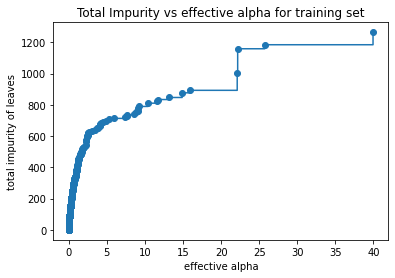

In [ ]:
##pruning the decision tree to reduce variance and overfitting

import matplotlib.pyplot as plt

clf = DecisionTreeRegressor()
path = clf.cost_complexity_pruning_path(X_train_train, y_train_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")




In [ ]:
print(len(ccp_alphas))

##to reduce the runtime, I'll take every 100th value of ccp_alphas
# and include the last 100 values
ccp_alphas = np.append(ccp_alphas[:-100:100], ccp_alphas[-100:])

12708


In [ ]:
len(ccp_alphas)

227

Number of nodes in the last tree is: 1 with ccp_alpha: 54.53541822630647


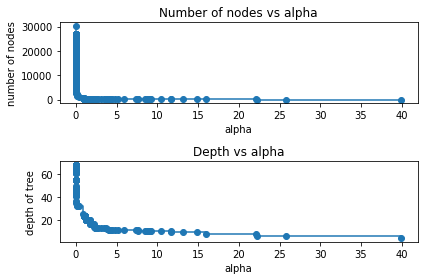

In [ ]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train_train, y_train_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()


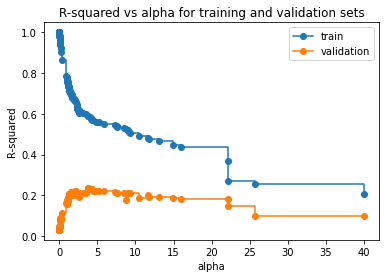

In [ ]:
train_scores = [clf.score(X_train_train, y_train_train) for clf in clfs]
val_scores = [clf.score(X_val, y_val) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("R-squared")
ax.set_title("R-squared vs alpha for training and validation sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, val_scores, marker="o", label="validation", drawstyle="steps-post")
ax.legend()
plt.show()

In [ ]:
print(val_scores)

[0.03091188753519125, 0.031226267500291782, 0.031226267500291782, 0.031226267500291782, 0.031226267500291782, 0.031226267500291782, 0.031226267500291782, 0.031226267500291782, 0.031226267500291782, 0.031226267500291782, 0.031226267500291782, 0.031226267500291782, 0.031226267500291782, 0.031226267500291782, 0.031226267500291782, 0.031226267500291782, 0.031228838552402327, 0.031188624245742647, 0.03114764843233153, 0.031161289458160324, 0.031156033444342257, 0.031138771218357952, 0.031160305054234616, 0.03117503595583826, 0.03123787850064963, 0.03123787850064963, 0.031241620841985562, 0.03125906015235458, 0.03122735089425821, 0.031228071618561115, 0.03136468828287309, 0.03135775680478403, 0.03134964865637724, 0.03157527846338992, 0.03157527846338992, 0.03157527846338992, 0.03157527846338992, 0.03157527846338992, 0.03157527846338992, 0.031555021990197774, 0.031566948526274285, 0.03158263012565565, 0.03157830569287601, 0.03155714100847151, 0.03156088067621465, 0.03158679194617864, 0.031560

In [ ]:
rmses = [np.sqrt(mse(clf.predict(X_val), y_val)) for clf in clfs]
print(rmses)
print('the minimum rmse is ',min(rmses))

[36.44770289919009, 36.44179045589918, 36.44179045589918, 36.44179045589918, 36.44179045589918, 36.44179045589918, 36.44179045589918, 36.44179045589918, 36.44179045589918, 36.44179045589918, 36.44179045589918, 36.44179045589918, 36.44179045589918, 36.44179045589918, 36.44179045589918, 36.44179045589918, 36.44174209899122, 36.44249845108053, 36.44326910946932, 36.443012555762124, 36.44311140849979, 36.44343606677515, 36.44303107000765, 36.44275401656513, 36.44157207316663, 36.44157207316663, 36.44150168595279, 36.44117367974814, 36.44177007919736, 36.44175652365663, 36.439186916402406, 36.43931729414663, 36.439469803897396, 36.43522559474287, 36.43522559474287, 36.43522559474287, 36.43522559474287, 36.43522559474287, 36.43522559474287, 36.43560664930225, 36.43538229380197, 36.43508729799375, 36.43516864768596, 36.435566787585635, 36.435496439064764, 36.435009007133985, 36.43551096704539, 36.43555466325654, 36.43561585184664, 36.43518090338641, 36.43498134931197, 36.43966973623992, 36.43

In [ ]:
print(node_counts)

[30223, 26913, 26913, 26913, 26913, 26913, 26913, 26913, 26913, 26913, 26913, 26913, 26913, 26913, 26913, 26913, 26865, 26599, 26247, 26169, 26005, 25779, 25587, 25415, 24981, 24981, 24801, 24595, 24393, 24183, 23937, 23671, 23581, 22229, 22229, 22229, 22229, 22229, 22229, 22107, 21713, 21661, 21429, 21235, 20959, 20813, 20529, 20367, 20137, 19949, 19737, 19203, 19203, 19123, 18889, 18679, 18401, 18211, 18003, 17785, 17559, 17245, 17143, 16931, 16723, 16493, 16281, 16037, 15831, 15577, 15367, 15155, 14907, 14701, 14457, 14227, 14003, 13703, 13503, 13283, 13045, 12779, 12533, 12321, 12065, 11837, 11579, 11345, 11107, 10865, 10613, 10385, 10141, 9873, 9639, 9379, 9087, 8895, 8591, 8391, 8101, 7905, 7651, 7405, 7145, 6861, 6591, 6337, 6081, 5811, 5507, 5221, 4957, 4709, 4389, 4111, 3821, 3483, 3183, 2873, 2571, 2275, 1947, 1645, 1327, 943, 507, 465, 463, 459, 433, 431, 429, 427, 425, 417, 415, 413, 411, 409, 407, 395, 393, 389, 381, 379, 377, 371, 353, 351, 343, 341, 335, 331, 315, 307, 3

In [ ]:
##number of nodes in tree that gives minimum rmse

index = np.where(rmses == min(rmses))
print('the number of nodes in the best decision tree is ',node_counts[index[0].item()])
print('the best ccp_alpha is', ccp_alphas[index].item())

the number of nodes in the best decision tree is  105
the best ccp_alpha is 3.742977327945989


In [ ]:
reg = DecisionTreeRegressor(ccp_alpha= 3.7429773279)
model = reg.fit(X_train_train,y_train_train)
pred = model.predict(X_val)
np.sqrt(mse(pred, y_val))

32.811906942764345

In [ ]:
# Hyperparameter tuning with GridSearchCV using ccp_alpha from above

from sklearn.model_selection import GridSearchCV

ccp_alpha = 3.74297732794

param_grid = { 
    'ccp_alpha': [ccp_alpha],
    'splitter': ['best','random'],
    'min_samples_leaf': [1,3,10],
    'min_weight_fraction_leaf': [0.0,0.2,0.5],
    'max_features': ['log2','sqrt',None],
    'max_depth': [None,5,50,100],
    'max_leaf_nodes': [None,10,50,100]
}

grid_cv = GridSearchCV(DecisionTreeRegressor(),
                          param_grid = param_grid, 
                          cv = 5,
                          verbose=0.5)

grid_cv.fit(X_train, y_train)

Fitting 5 folds for each of 864 candidates, totalling 4320 fits


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'ccp_alpha': [3.74297732794],
                         'max_depth': [None, 5, 50, 100],
                         'max_features': ['log2', 'sqrt', None],
                         'max_leaf_nodes': [None, 10, 50, 100],
                         'min_samples_leaf': [1, 3, 10],
                         'min_weight_fraction_leaf': [0.0, 0.2, 0.5],
                         'splitter': ['best', 'random']},
             verbose=0.5)

In [ ]:
grid_cv.best_params_

{'ccp_alpha': 3.74297732794,
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'splitter': 'best'}

In [ ]:
reg = DecisionTreeRegressor(ccp_alpha=3.74297732794, 
                            max_depth = 5,
                            max_features = None,
                            max_leaf_nodes = None,
                            min_samples_leaf = 1,
                            min_weight_fraction_leaf = 0.0,
                            splitter = 'best')
model = reg.fit(X_train_train, y_train_train) 
pred = model.predict(X_val)

In [ ]:
print('rmse is', np.sqrt(mse(y_val, pred)))

rmse is 33.27784044805932


In [13]:
# Getting test set rmse from best model above.

reg = DecisionTreeRegressor(
    max_depth=7,
    max_features=None,
    min_samples_leaf=5,
    min_samples_split=30,
    min_weight_fraction_leaf = 0,
    splitter='best'
)
model = reg.fit(X_train,y_train)
pred = model.predict(X_test)

print('rmse on the test set is', np.sqrt(mse(y_test, pred)))

rmse on the test set is 32.41119244691474


# Random forest regressors

In [9]:
# Random forest regressor with default hyperparameters

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse

reg = RandomForestRegressor()
model = reg.fit(X_train_train,y_train_train)
pred = model.predict(X_val)

print('rmse is ', np.sqrt(mse(y_val,pred)))

rmse is  27.79756638485477


In [8]:
# Hyperparameter tuning with GridSearchCV 
# With more time, I would tune more hyperparameters

from sklearn.model_selection import GridSearchCV

param_grid = { 
    'n_estimators': [200, 500, 1000],
    'max_features': [None],
    'max_depth' : [2, 5, 10, 100, None]
}

grid_cv = GridSearchCV(RandomForestRegressor(),
                          param_grid = param_grid, 
                          cv = 5,
                          verbose=1)

grid_cv.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [2, 5, 10, 100, None],
                         'max_features': [None],
                         'n_estimators': [200, 500, 1000]},
             verbose=1)

In [9]:
# Best hyperparameters from GridSearchCV above

grid_cv.best_params_

{'max_depth': None, 'max_features': None, 'n_estimators': 200}

In [10]:
# Fitting a model with the best hyperparameters

reg = RandomForestRegressor(max_depth=None,
                            max_features=None,
                            n_estimators=200)
model = reg.fit(X_train_train, y_train_train)
pred = model.predict(X_val)
print('rmse is', np.sqrt(mse(y_val, pred)))

rmse is 27.608551580242747


In [10]:
# Get rmse for test set

reg = RandomForestRegressor(max_depth=None,
                            max_features=None,
                            n_estimators=200)
model = reg.fit(X_train, y_train)
pred = model.predict(X_test)
print('rmse is', np.sqrt(mse(y_test, pred)))

rmse is 27.92586254078418


In [11]:
# Given more time, I would fine-tune the hyperparameters and
#  tune more hyperparameters

# Extra trees regressor

In [6]:
# Extra tree regressor with default hyperparameters

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_squared_error as mse 

reg = ExtraTreesRegressor()
model = reg.fit(X_train_train, y_train_train)
pred = model.predict(X_val)

print('rmse is', np.sqrt(mse(pred, y_val)))

rmse is 28.194632818655215


In [7]:
# Increase the number of estimators
# With more time, I would tune hyperparameters

reg = ExtraTreesRegressor(n_estimators = 1000)
model = reg.fit(X_train_train, y_train_train) 
pred = model.predict(X_val)

print('rmse is', np.sqrt(mse(pred, y_val)))

rmse is 28.36173942460358


In [8]:
# Get test set error on better of the two

reg = ExtraTreesRegressor()
model = reg.fit(X_train, y_train)
pred = model.predict(X_test)

print('rmse is', np.sqrt(mse(pred, y_test)))

rmse is 29.637591863329945
